In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [65]:
# Load the prepared data
X = np.load('../key_experiments/data/X_6hr_.npy')
y = np.load('../key_experiments/data/y_6hr.npy')


In [67]:
X.shape

(19752, 48, 52)

In [69]:
y.shape

(19752,)

In [71]:
count_ones = np.sum(y == 1)

count_zeros = np.sum(y == 0)

print(f"Number of 1s: {count_ones}")
print(f"Number of 0s: {count_zeros}")

Number of 1s: 7905
Number of 0s: 11847


In [73]:
X[0].shape

(48, 52)

In [75]:
X[0]

array([[-0.57054595, -0.81909528, -0.85600678, ..., -0.04447006,
        -0.82824677, -0.62655636],
       [-0.57054595, -0.81909528, -0.85600678, ..., -0.04447006,
        -0.82824677, -0.62655636],
       [-0.57054595, -0.81909528, -0.85600678, ..., -0.04447006,
        -0.82824677, -0.62655636],
       ...,
       [-0.57054595,  0.80814734,  1.13763819, ...,  0.05382138,
         1.09951283,  0.1238337 ],
       [-0.57054595,  0.80814734,  1.13763819, ...,  0.04772579,
         1.09951283,  1.73920539],
       [-0.57054595,  0.80814734,  1.13763819, ...,  0.05382138,
         1.09951283,  2.65347374]])

In [77]:
X[0][15]

array([-0.57054595, -0.81909528, -0.85600678, -0.80580948, -0.00663536,
       -0.00801255, -0.00247501, -0.04378329, -0.17437335, -0.14094295,
       -0.86304513, -0.8562083 , -0.00171422, -0.85222277, -0.86244136,
       -0.76983723, -0.85192774, -0.86311731, -0.86323765, -0.84896257,
       -0.82775361, -0.84026428, -0.40478398, -0.86187658, -0.86290237,
       -0.86271939, -0.86294372, -0.52636884, -0.86286557, -0.51820598,
       -0.85399685, -0.83580947, -0.85861559, -0.86298337, -0.86286346,
       -0.72882187, -0.86066902, -0.85894785, -0.86207401, -0.86127118,
       -0.85831261, -0.45699742, -0.81449823, -0.86245966, -0.02695423,
       -0.01925655, -0.86226279, -0.82026648, -0.8594825 , -0.04447006,
       -0.82824677, -0.62655636])

In [79]:
unique_values, counts = np.unique(y, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f'Value {value} occurs {count} times')

Value 0 occurs 11847 times
Value 1 occurs 7905 times


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [83]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# Define Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Multi-Head Self-Attention
    attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([attention, inputs])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)  # Layer normalization

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)  # Project back to original input shape
    ff = Add()([ff, attention])  # Residual connection
    ff = LayerNormalization(epsilon=1e-6)(ff)  # Layer normalization
    return ff

# Input layer for feature data (shape: 48 time steps, 51 features)
inputs = Input(shape=(48, 52))

# Transformer encoder layers for feature data
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

# LSTM layers to capture sequential dependencies
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(32, activation='relu')(x)

# Fully connected layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 48, 52)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_4        │ (None, 48, 52)            │          54,068 │ input_layer_2[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_15 (Dropout)          │ (None, 48, 52)            │               0 │ multi_head_attention_4[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_8 (Add)                   │ (None, 48, 52)            │               0 │ dropout_15[0][0],          │
│                               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_8         │ (None, 48, 52)            │             104 │ add_8[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 48, 128)           │           6,784 │ layer_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 48, 128)           │               0 │ dense_12[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 48, 52)            │           6,708 │ dropout_16[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 48, 52)            │               0 │ dense_13[0][0],            │
│                               │                           │                 │ layer_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_9         │ (None, 48, 52)            │             104 │ add_9[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_5        │ (None, 48, 52)            │          54,068 │ layer_normalization_9[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_18 (Dropout)          │ (None, 48, 52)            │               0 │ multi_head_attention_5[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_10 (Add)                  │ (None, 48, 52)            │               0 │ dropout_18[0][0],          │
│                               │                           │                 │ layer_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 48, 52)            │             10

 Total params: 178,993 (699.19 KB)

 Trainable params: 178,993 (699.19 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:

# from tensorflow.keras.callbacks import EarlyStopping
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# # Train the model with Early Stopping
# history = model.fit(X_train, 
#                     y_train, 
#                     epochs=30, 
#                     batch_size=64, 
#                     validation_split=0.2)

# # Save the model
# # model.save('lstm_model_advanced.h5')

# # Save the model
# # model.save('lstm_model_advanced.h5')




history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)



Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7233 - loss: 0.5705 - val_accuracy: 0.7798 - val_loss: 0.5026
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.7754 - loss: 0.4931 - val_accuracy: 0.7985 - val_loss: 0.4767
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.8123 - loss: 0.4432 - val_accuracy: 0.8285 - val_loss: 0.3923
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8218 - loss: 0.4303 - val_accuracy: 0.7713 - val_loss: 0.4662
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.8245 - loss: 0.4121 - val_accuracy: 0.8510 - val_loss: 0.3742
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.8375 - loss: 0.3828 - val_accuracy: 0.8567 - val_loss: 0.3442
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.8454 - loss: 0.3700 - val_accuracy: 0.8618 - val_loss: 0.3392
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8455 - loss: 0.3695 - 

In [54]:
# model.save('lstm_transformer_model_50epoch.h5')

In [89]:
# Step 3: Evaluate the model
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
y_pred_proba = model.predict(X_test)
y_pred = (model.predict(X_test) > 0.35).astype(int)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')


124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Precision: 0.87
Recall: 0.84
F1 Score: 0.85
Accuracy: 0.88


In [91]:
np.save('../Scores/validation_loss/LT6-VL.npy', np.array(history.history['val_loss']))
np.save('../Scores/validation_accuracy/LT6-VA.npy', np.array(history.history['val_accuracy']))
np.save('../Scores/training_accuracy/LT6-TA.npy', np.array(history.history['accuracy']))
np.save('../Scores/training_loss/LT6-TL.npy', np.array(history.history['loss']))


np.save('../Scores/ROC-PRC/LT6-y_test.npy', np.array(y_test))
np.save('../Scores/ROC-PRC/LT6-y_pred.npy', np.array(y_pred))
np.save('../Scores/ROC-PRC/LT6-y_pred_proba.npy', np.array(y_pred_proba))

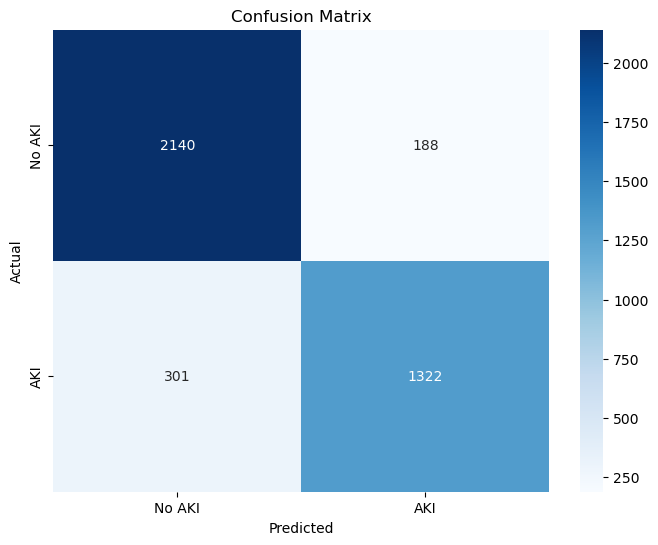

In [44]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

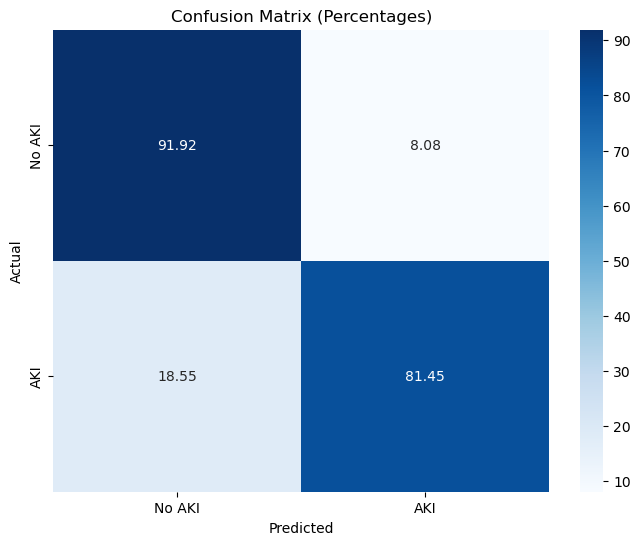

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentages)')
plt.show()

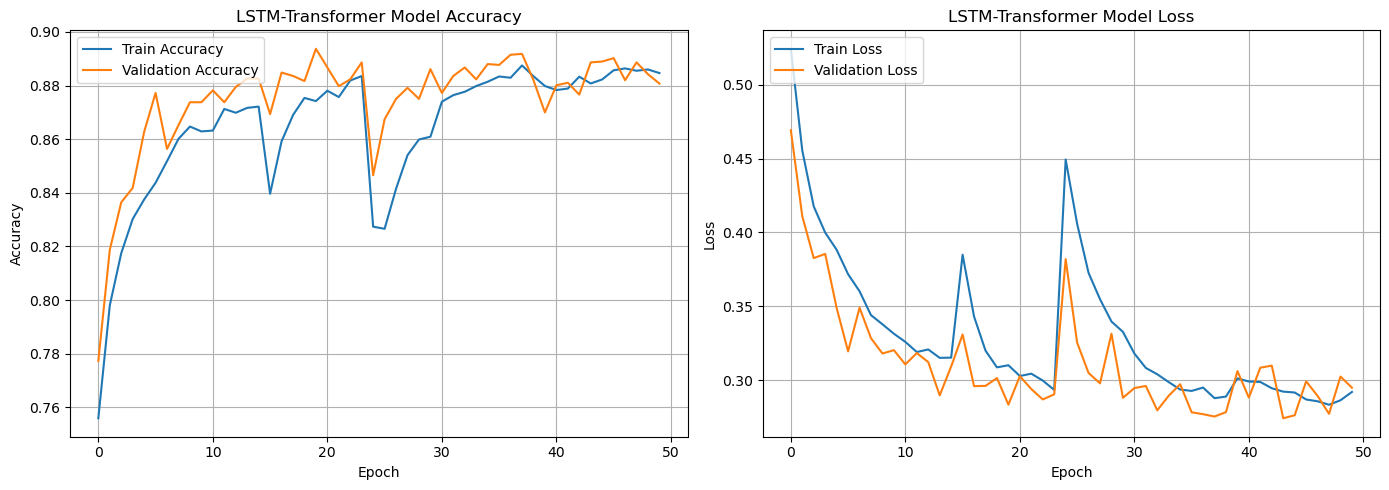

In [48]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM-Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM-Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


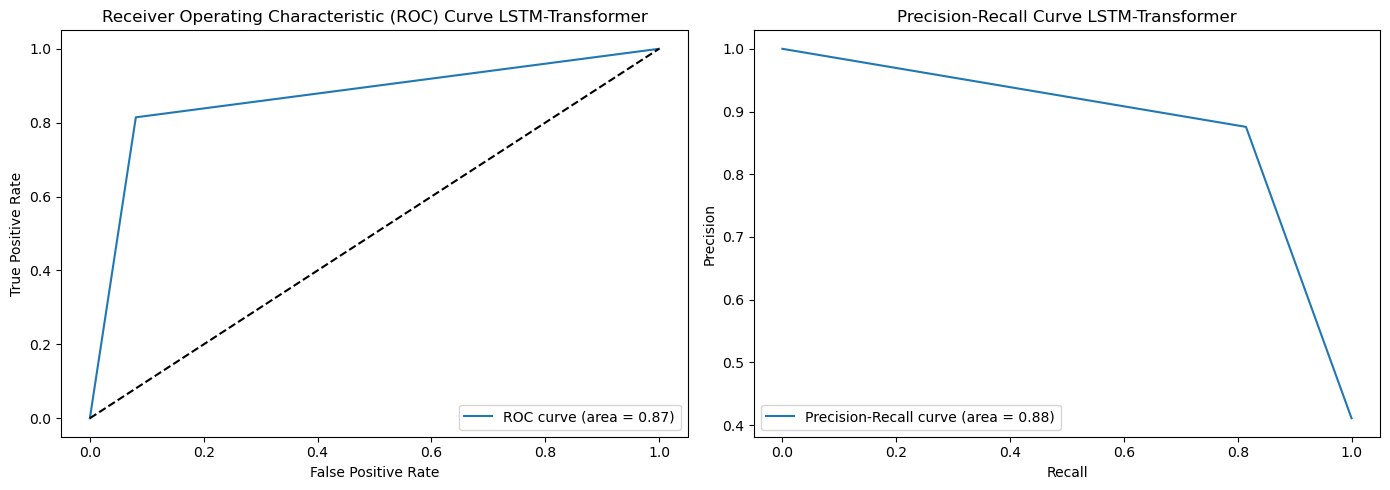

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Assuming y_true are the true labels and y_scores are the predicted probabilities

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

# Calculate Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve LSTM-Transformer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.title('Precision-Recall Curve LSTM-Transformer')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()